In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Pretreatment

In [2]:
data_r = pd.read_csv('./hw1_data/train.csv', encoding='big5')
data_r[data_r == 'NR'] = 0

In [3]:
arr_r = np.array(data_r.loc[:,'0':'23']).astype(float)
arr_r.shape

(4320, 24)

In [4]:
'''
训练数据是12个月，每个月前20天，每天的18种指标组成
4320 = 12*20*18

最终列表为：12, 18, 20*24
'''
month_data = {}
for month in range(12):
    sample = np.empty([18,480]) # Hourly indicators in a month
    for day in range(20):
        sample[:, day*24:(day+1)*24] = arr_r[18*(month*20 + day):18*(month*20 + day + 1),:]
    month_data[month] = sample

In [5]:
'''
每个月按10h一组数据来制作训练集,
每个月可以提取出20*24-9=471组数据,
最终训练集有12*471组，每组18个feature，每个feature有9h的数据
'''
X=np.empty([12*471, 18*9], dtype=float)
y=np.empty([12*471, 1], dtype=float)

for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            X[month*471 + day*24 + hour, :] = month_data[month][:, day*24 + hour:day*24 + hour + 9].reshape(1,-1)
            y[month*471 + day*24 + hour, 0] = month_data[month][9, day*24 + hour + 9]
X.shape,y.shape

((5652, 162), (5652, 1))

In [6]:
'''
归一化
'''
def normalize(x,fun='mean_std'):
    if fun == 'mean_std':
        mean = np.mean(x, axis=0)
        std = np.std(x, axis=0)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if std[j] != 0:
                    x[i][j] = (x[i][j] - mean[j]) / std[j]
    return x

In [7]:
normalize(X)

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

In [8]:
'''
划分训练集，验证集和测试集：
60% 训练集
20% 验证集
20% 测试集
'''
num = X.shape[0]
num_tr = np.floor(num*0.6).astype(int)
num_val = np.floor(num*0.2).astype(int)
num_tst = num - num_tr - num_val

print('Training set：{};Validation set：{};Test set：{}'.format(num_tr, num_val, num_tst))

row_rand_arr = np.arange(num)
np.random.shuffle(row_rand_arr)

# 验证集
X_val = X[row_rand_arr[0:num_val], :]
y_val = y[row_rand_arr[0:num_val], :]

# 测试集
X_tst = X[row_rand_arr[num_val:num_val + num_tst], :]
y_tst = y[row_rand_arr[num_val:num_val + num_tst], :]

# 训练集
X = X[row_rand_arr[- num_tr:], :]
y = y[row_rand_arr[- num_tr:], :]

X.shape,y.shape,X_val.shape,y_val.shape,X_tst.shape,y_tst.shape

Training set：3391;Validation set：1130;Test set：1131


((3391, 162), (3391, 1), (1130, 162), (1130, 1), (1131, 162), (1131, 1))

In [9]:
def cost(w, x, y):
    return np.sqrt(np.sum((x@w - y)**2)/x.shape[0])

def cost2(w, x, y):
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    return np.sqrt(np.sum((x@w - y)**2)/x.shape[0])

def predict(w, x):
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    return x@w

def Adagrad(x, y, learning_rate=1, iter_time=1000):
    x = x.copy()
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    w = np.random.rand(x.shape[1], 1)
    adagrad =np.zeros_like(w)
    eps = 1e-9
    costs = np.zeros(iter_time)
    for it in range(iter_time):
        costs[it] = cost(w, x, y)
        gradient = 2*x.T@(x@w - y)
        adagrad += gradient**2
        w = w - learning_rate/np.sqrt(adagrad + eps) * gradient
    return w, costs

def RMSProp(x, y, learning_rate=1, iter_time=1000, alpha=0.5):
    x = x.copy()
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    w = np.random.rand(x.shape[1], 1)
    rms =np.zeros_like(w)
    eps = 1e-8
    costs = np.zeros(iter_time)
    for it in range(iter_time):
        costs[it] = cost(w, x, y)
        gradient = 2*x.T@(x@w - y)
        rms = alpha * rms + (1- alpha)*gradient**2
        w = w - learning_rate/np.sqrt(rms + eps) * gradient
    return w, costs

def SGDM(x, y, learning_rate=1, iter_time=1000, beta=0.999):
    x = x.copy()
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    w = np.random.rand(x.shape[1], 1)
    movement = np.zeros_like(w)
    costs = np.zeros(iter_time)
    for it in range(iter_time):
        costs[it] = cost(w, x, y)
        gradient = 2*x.T@(x@w - y)
        movement = beta * movement + (1- beta) * gradient
        w = w - learning_rate * movement 
    return w, costs

def Adam(x, y, learning_rate=1, iter_time=1000, alpha=0.9, beta=0.999):
    x = x.copy()
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    w = np.random.rand(x.shape[1], 1)
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    costs = np.zeros(iter_time)
    eps = 1e-8
    times = 0 
    for it in range(iter_time):
        times+=1
        costs[it] = cost(w, x, y)
        gradient = 2*x.T@(x@w - y)
        m = beta * m + (1- beta) * gradient
        v = alpha * v + (1- alpha) * gradient**2
        m_hat = m/(1 - beta**times)
        v_hat = v/(1- alpha**times)
        w = w - learning_rate * m_hat / (np.sqrt(v_hat) + eps)  
    return w, costs

## Adagrad

In [10]:
w, costs = Adagrad(X, y, learning_rate=1)

Text(0, 0.5, 'cost')

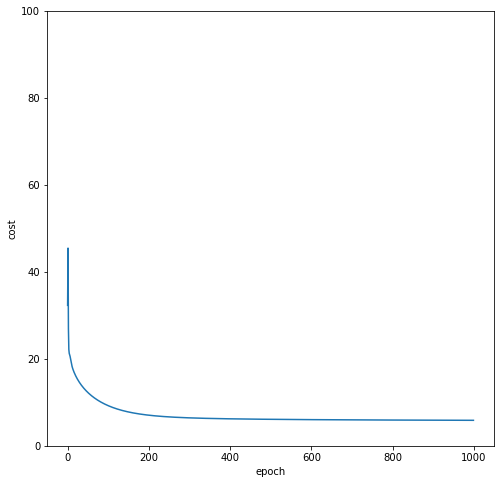

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(range(costs.shape[0]), costs)
ax.set_ylim((0,100))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')

In [12]:
print('训练集代价:{};\n验证集代价:{};\n测试集代价:{};'.format(cost2(w, X, y), cost2(w, X_val, y_val), cost2(w, X_tst, y_tst)))

训练集代价:5.86153436653296;
验证集代价:5.802623477127874;
测试集代价:6.017159002416388;


## RMSProp

In [13]:
w2, costs2 = RMSProp(X, y, learning_rate=0.1, alpha=0.5)

Text(0, 0.5, 'cost')

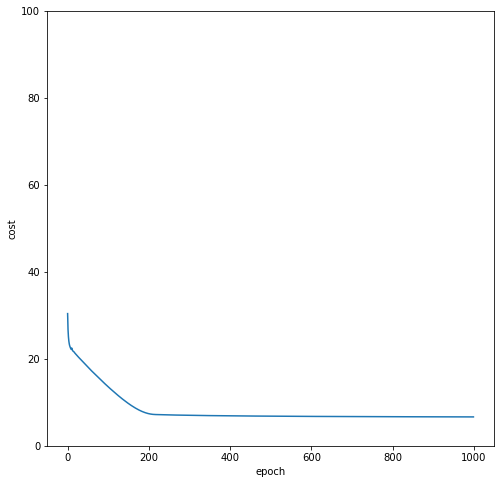

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(range(costs2.shape[0]), costs2)
ax.set_ylim((0,100))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')

In [15]:
print('训练集代价:{};\n验证集代价:{};\n测试集代价:{};'.format(cost2(w2, X, y), cost2(w2, X_val, y_val), cost2(w2, X_tst, y_tst)))

训练集代价:6.643403069866657;
验证集代价:6.62330500423165;
测试集代价:6.724947479773392;


## SGDM

In [16]:
w3, costs3 = SGDM(X, y, learning_rate=0.00001, beta=0.5)

Text(0, 0.5, 'cost')

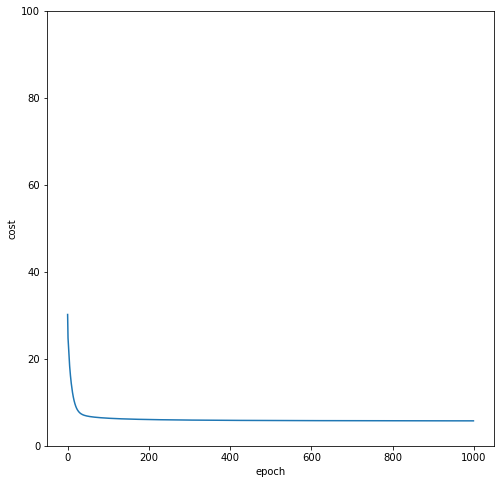

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(range(costs3.shape[0]), costs3)
ax.set_ylim((0,100))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')

In [18]:
print('训练集代价:{};\n验证集代价:{};\n测试集代价:{};'.format(cost2(w3, X, y), cost2(w3, X_val, y_val), cost2(w3, X_tst, y_tst)))

训练集代价:5.73792449494394;
验证集代价:5.671802435339253;
测试集代价:5.938918584515743;


## Adam

In [19]:
w4, costs4 = Adam(X, y, learning_rate=0.1, iter_time=1000,alpha=0.9, beta=0.9)

Text(0, 0.5, 'cost')

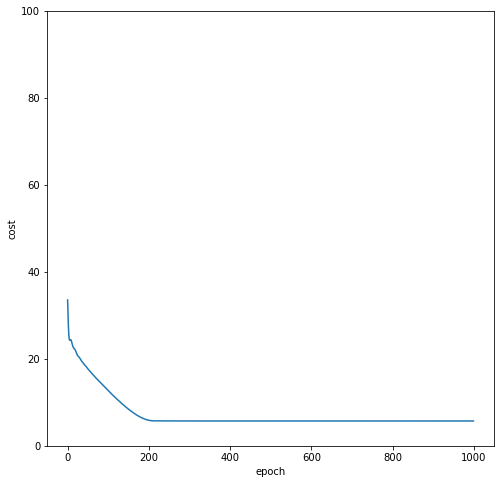

In [20]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(range(costs4.shape[0]), costs4)
ax.set_ylim((0,100))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')

In [21]:
print('训练集代价:{};\n验证集代价:{};\n测试集代价:{};'.format(cost2(w4, X, y), cost2(w4, X_val, y_val), cost2(w4, X_tst, y_tst)))

训练集代价:5.706816559954323;
验证集代价:5.678499748849531;
测试集代价:5.9598773305618264;


In [22]:
# 选取测试集代价最好的weigth
np.save('weight.npy',w4)

## Predict

In [23]:
data_tst= pd.read_csv('./hw1_data/test.csv', header=None, encoding='big5')
data_tst[data_tst=='NR'] = 0
data_tst.head(18)

,0,1,2,3,4,5,6,7,8,9,10
0,id_0,AMB_TEMP,21,21,20,20,19,19,19,18,17
1,id_0,CH4,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.8
2,id_0,CO,0.39,0.36,0.36,0.4,0.53,0.55,0.34,0.31,0.23
3,id_0,NMHC,0.16,0.24,0.22,0.27,0.27,0.26,0.27,0.29,0.1
4,id_0,NO,1.3,1.3,1.3,1.3,1.4,1.6,1.2,1.1,0.9
5,id_0,NO2,17,14,13,14,18,21,8.9,9.4,5
6,id_0,NOx,18,16,14,15,20,23,10,10,5.8
7,id_0,O3,32,31,31,26,16,12,27,20,26
8,id_0,PM10,62,50,44,39,38,32,48,36,25
9,id_0,PM2.5,33,39,39,25,18,18,17,9,4


In [24]:
arr_tst = np.array(data_tst.iloc[:, 2:11]).astype(float)
arr_tst.shape

(4320, 9)

In [25]:
'''
4320 = 240 * 18
'''
test_X = np.empty([240, 18*9])
for i in range(240):
    test_X[i, :] = arr_tst[i*18:(i+1)*18, :].reshape(1,-1)
normalize(test_X)
test_X

array([[-0.36400913, -0.37580621, -0.58294053, ..., -0.70121844,
        -1.02610681,  0.04822449],
       [-1.56616232, -1.76339837, -1.82418271, ...,  0.1100466 ,
        -0.16353016, -0.45136733],
       [ 1.52508875,  1.35868399,  1.54490322, ..., -1.33220237,
        -1.02610681, -0.53463264],
       ...,
       [ 0.32293556,  0.49143889,  0.65830166, ...,  0.20018716,
        -0.24978782,  1.04740813],
       [-2.08137084, -2.11029642, -2.17882334, ..., -1.06178069,
        -1.11236448, -1.03422446],
       [-1.56616232, -1.58994935, -1.6468624 , ...,  2.81426342,
         2.94174581,  1.54699995]])

In [26]:
w = np.load('./weight.npy')
pred_y = predict(w, test_X)

In [27]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), pred_y[i][0]]
        csv_writer.writerow(row)